# Imports

In [23]:
import matplotlib.pyplot as plt
import torch
import random  
import numpy as np
import json
from sklearn.model_selection import train_test_split
import torch

# Code

Set the paths and import the label array

In [24]:
# Define the path to the folder containing the images and labels
path = "../../Datasets/Real life data/"

# Load the labels from the tensor file
labels = torch.load(path+'y_real_life.pt')

print("Labels loaded")
print("Number of images: ", len(labels))

Labels loaded
Number of images:  32000


We now plot the distribution of the real life data before removing training examples that are empty squares to rebalance the data. We save that plot in a JSON file to be able to easily plot this data later if necessary. We expect a lot of empty squares in the data.

In [25]:
# Define the class_names dictionary
class_names = {
    0: 'Empty', 1: 'White pawn', 2: 'White knight', 3: 'White bishop', 4: 'White rook',
    5: 'White queen', 6: 'White king', 7: 'Black pawn', 8: 'Black knight', 9: 'Black bishop',
    10: 'Black rook', 11: 'Black queen', 12: 'Black king'
}

# Compute the class distribution
class_distribution_dict = {}
class_distributions = {}
for label in sorted(labels):
    class_name = class_names[label.item()]
    class_distributions[class_name] = class_distributions.get(class_name, 0) + 1
class_distribution_dict["full"] = class_distributions

# Save the class distribution to a JSON file
json_file = "class_distribution.json"
with open(json_file, 'w') as f:
    json.dump(class_distribution_dict, f)

print("Class distribution saved to", json_file)
print(class_distribution_dict)

Class distribution saved to class_distribution.json
{'full': {'Empty': 22445, 'White pawn': 2452, 'White knight': 489, 'White bishop': 586, 'White rook': 641, 'White queen': 291, 'White king': 500, 'Black pawn': 2103, 'Black knight': 401, 'Black bishop': 653, 'Black rook': 609, 'Black queen': 330, 'Black king': 500}}


We now use the computed class distribution and plot them on a histogram. We can see that the data is very unbalanced. We will now remove empty squares from the training set to rebalance the data.

In [26]:
def plot_class_distribution(class_distribution):
    # Extract class names and frequencies from the JSON data
    class_names = list(class_distribution.keys())
    frequencies = list(class_distribution.values())

    # Calculate the total count
    total_count = sum(frequencies)

    # Calculate the percentage for each frequency
    percentages = [count / total_count * 100 for count in frequencies]

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names, frequencies)
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Class Distribution")
    plt.xticks(rotation=90)

    # Add the percentage labels to the bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{percentages[i]:.2f}%", ha='center', va='bottom')

    # Display the plot
    plt.tight_layout()
    plt.show()

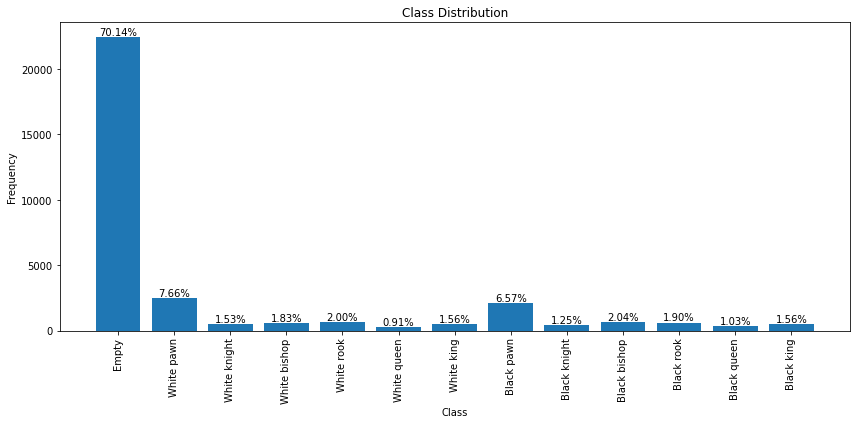

In [27]:
# Load the class ditribution from the JSON file
with open("class_distribution.json", "r") as f:
    class_distribution = json.load(f)
    
plot_class_distribution(class_distribution["full"])

Based on the histogram, it is evident that empty squares make up the majority, comprising about 70% of the images. Moreover, and as expected, pawns have the highest proportion among the chess pieces (around 13% in total). Additionally, the proportion of white and black pieces is similar for each piece. For instance, the proportion of the white queen is 0.91%, while that of the black queen is 1.03%.

In this context, the imbalance in the data due to the abundance of empty squares may cause the model to have a bias towards identifying empty squares rather than chess pieces. To mitigate this issue, a pre-processing step is suggested, which involves removing a significant portion of training examples that correspond to empty squares. The objective is to provide a more balanced data set, where the number of training examples that are empty squares is equal to the number of training examples that correspond to pawns (black and white combined). This step helps to improve the focus of the model on recognizing chess pieces rather than empty squares, which may not contain any useful information for the classification task. Additionally, too many empty squares may hinder domain adaptation since empty squares are similar across both domains. Furthermore, since empty squares are easy to recognize, their over-representation may lead the model to overfit to empty squares rather than the task of identifying chess pieces. Finally, it is worth noting that other classes such as knight, king, etc. are kept unchanged since they are critical for the classification task.

# Saving the full Real Life Dataset splitted into train, validation and test sets

We first split the full real life dataset into train, validation and test sets. We keep all images in the same folder in "Datasets/Real Life Data" to avoid having duplicates (since we will also have a Real Life Dataset with most empty squares removed). We thus create three JSON files (one for each set) that contain the paths to the images in each set. Each JSON file has the name of the images as keys and the corresponding label as values. We save the JSON files in "Datasets/Real Life Data".

In [28]:
# Set the seed for reproducibility
np.random.seed(42)

# Number of images
num_images = labels.shape[0]

# Generate indices for shuffling
indices = np.arange(num_images)

# Shuffle the indices randomly
np.random.shuffle(indices)

# Split the indices into training, validation, and testing sets. Use an 80/10/10 split.
train_indices, val_test_indices = train_test_split(indices, test_size=0.2)
val_indices, test_indices = train_test_split(val_test_indices, test_size=0.5)

# Create dictionaries to store the image names for each set
train_set = {"train": [], "label": []}
val_set = {"validation": [], "label": []}
test_set = {"test": [], "label": []}

# Iterate over the indices and assign image names to the corresponding sets
for index in train_indices:
    image_name = f"EX_{str(index).zfill(6)}.png"
    train_set["train"].append(image_name)
    train_set["label"].append(labels[index].item())

for index in val_indices:
    image_name = f"EX_{str(index).zfill(6)}.png"
    val_set["validation"].append(image_name)
    val_set["label"].append(labels[index].item())

for index in test_indices:
    image_name = f"EX_{str(index).zfill(6)}.png"
    test_set["test"].append(image_name)
    test_set["label"].append(labels[index].item())

# Save the sets as JSON files
with open(path+"train_full_real_life_data.json", "w") as train_file:
    json.dump(train_set, train_file)

with open(path+"validation_full_real_life_data.json", "w") as val_file:
    json.dump(val_set, val_file)

with open(path+"test_full_real_life_data.json", "w") as test_file:
    json.dump(test_set, test_file)

# Print the size of each set
print("Training set size:", len(train_set["train"]))
print("Validation set size:", len(val_set["validation"]))
print("Testing set size:", len(test_set["test"]))

Training set size: 25600
Validation set size: 3200
Testing set size: 3200


Re-compute the class distributions in each of the train, validation, and test sets.

In [29]:
json_file = "class_distribution.json"

def sort_and_return(list):
    list.sort()
    return list

# Extract the frequency of each class
class_distributions_train = {}
for label in sort_and_return(train_set["label"]):
    class_name = class_names[label]
    class_distributions_train[class_name] = class_distributions_train.get(class_name, 0) + 1
class_distribution_dict["train"] = class_distributions_train

class_distributions_val = {}
for label in sort_and_return(val_set["label"]):
    class_name = class_names[label]
    class_distributions_val[class_name] = class_distributions_val.get(class_name, 0) + 1
class_distribution_dict["validation"] = class_distributions_val

class_distributions_test = {}
for label in sort_and_return(test_set["label"]):
    class_name = class_names[label]
    class_distributions_test[class_name] = class_distributions_test.get(class_name, 0) + 1
class_distribution_dict["test"] = class_distributions_test

# Overwrite the distribution json file
with open(json_file, 'w') as f:
    f.seek(0)
    json.dump(class_distribution_dict, f)

# Sanity check
print(class_distribution_dict)

{'full': {'Empty': 22445, 'White pawn': 2452, 'White knight': 489, 'White bishop': 586, 'White rook': 641, 'White queen': 291, 'White king': 500, 'Black pawn': 2103, 'Black knight': 401, 'Black bishop': 653, 'Black rook': 609, 'Black queen': 330, 'Black king': 500}, 'train': {'Empty': 17944, 'White pawn': 1987, 'White knight': 384, 'White bishop': 447, 'White rook': 519, 'White queen': 244, 'White king': 395, 'Black pawn': 1677, 'Black knight': 323, 'Black bishop': 531, 'Black rook': 482, 'Black queen': 270, 'Black king': 397}, 'validation': {'Empty': 2229, 'White pawn': 238, 'White knight': 50, 'White bishop': 70, 'White rook': 67, 'White queen': 30, 'White king': 60, 'Black pawn': 214, 'Black knight': 39, 'Black bishop': 53, 'Black rook': 59, 'Black queen': 33, 'Black king': 58}, 'test': {'Empty': 2272, 'White pawn': 227, 'White knight': 55, 'White bishop': 69, 'White rook': 55, 'White queen': 17, 'White king': 45, 'Black pawn': 212, 'Black knight': 39, 'Black bishop': 69, 'Black roo

# Saving the Real Life Dataset splitted into train, validation and test sets with most empty squares removed

We will now also save three JSON files containing the training, validation, and testing sets, respectively. However, before saving the sets, we will remove some empty squares from the dataset. The goal is to ensure that the total number of empty squares across all sets is equal to the total number of pawns (black and white combined).

To achieve this, we will remove empty squares from the training, validation, and testing sets while ensuring that the remaining sets still contain the same images as the original sets. This step is important because we want to ensure that the model is not tested on images it was trained on (if we try to train the models on the real life data directly).

By preserving the same images across the sets without empty squares, we maintain consistency between the sets with and without empty squares.

To accomplish this task, we will follow the following steps:

1. Load the three JSON files created in the previous step, containing the original training, validation, and testing sets.
2. Compute the total number of chess pawns (black and white combined) across the three sets.
3. Determine the number of empty squares to remove to ensure that the total number of empty squares matches the total number of chess pawns.
4. Calculate the proportion of empty squares to remove, based on the computed values.
5. Remove the corresponding percentage of empty squares from each set, maintaining the same proportion in the training, validation, and testing sets.
6. Save the modified datasets as new JSON files, using the same format as the previous ones, but with the empty squares removed.

By following these steps, we can generate new JSON files that contain the modified datasets without the selected empty squares, while preserving the consistency and proportionality of the original sets.

In [11]:
# Load the original datasets
with open(path+"train_full_real_life_data.json", "r") as f:
    train_data = json.load(f)
    
with open(path+"validation_full_real_life_data.json", "r") as f:
    validation_data = json.load(f)
    
with open(path+"test_full_real_life_data.json", "r") as f:
    test_data = json.load(f)

# Store IDS to count the number of pawns and empty squares
white_pawn_id = 1
black_pawn_id = 7
empty_id = 0

total_pawns = train_data["label"].count(white_pawn_id) + train_data["label"].count(black_pawn_id) + \
                validation_data["label"].count(white_pawn_id) + validation_data["label"].count(black_pawn_id) + \
                test_data["label"].count(white_pawn_id) + test_data["label"].count(black_pawn_id)

# Compute the number of empty squares to remove
total_empty_squares = train_data["label"].count(empty_id) + validation_data["label"].count(empty_id) + test_data["label"].count(empty_id)
empty_squares_to_remove = total_empty_squares - total_pawns

# Calculate the percentage of empty squares to remove
percentage_to_remove = empty_squares_to_remove / total_empty_squares

# Randomly select and remove empty squares from each set
random.seed(42)  # For reproducibility

train_balanced_data = {"train": [], "label": []}
validation_balanced_data = {"validation": [], "label": []}
test_balanced_data = {"test": [], "label": []}

for image, label in zip(train_data["train"], train_data["label"]):
    if label != empty_id or random.random() > percentage_to_remove:
        train_balanced_data["train"].append(image)
        train_balanced_data["label"].append(label)

for image, label in zip(validation_data["validation"], validation_data["label"]):
    if label != empty_id or random.random() > percentage_to_remove:
        validation_balanced_data["validation"].append(image)
        validation_balanced_data["label"].append(label)

for image, label in zip(test_data["test"], test_data["label"]):
    if label != empty_id or random.random() > percentage_to_remove:
        test_balanced_data["test"].append(image)
        test_balanced_data["label"].append(label)

# Save the modified datasets as new JSON files
with open(path+"train_balanced_real_life_data.json", "w") as f:
    json.dump(train_balanced_data, f)

with open(path+"validation_balanced_real_life_data.json", "w") as f:
    json.dump(validation_balanced_data, f)

with open(path+"test_balanced_real_life_data.json", "w") as f:
    json.dump(test_balanced_data, f)

# Print the size of each set
print("Training set size:", len(train_balanced_data["train"]))
print("Validation set size:", len(validation_balanced_data["validation"]))
print("Testing set size:", len(test_balanced_data["test"]))

# Print the number of empty squares in each set
print("Number of empty squares in training set:", train_balanced_data["label"].count(empty_id))
print("Number of empty squares in validation set:", validation_balanced_data["label"].count(empty_id))
print("Number of empty squares in testing set:", test_balanced_data["label"].count(empty_id))

Training set size: 11290
Validation set size: 1452
Testing set size: 1374
Number of empty squares in training set: 3634
Number of empty squares in validation set: 481
Number of empty squares in testing set: 446


We now save the new class distribution after removing empty squares from all sets. We can see that the data is now more balanced. We save that plot in a JSON file to be able to easily plot this data later if necessary.

In [12]:
# Define the class_names dictionary
class_names = {
    0: 'Empty', 1: 'White pawn', 2: 'White knight', 3: 'White bishop', 4: 'White rook',
    5: 'White queen', 6: 'White king', 7: 'Black pawn', 8: 'Black knight', 9: 'Black bishop',
    10: 'Black rook', 11: 'Black queen', 12: 'Black king'
}

# Load the three JSON files
with open(path+"train_balanced_real_life_data.json", "r") as f:
    train_data = json.load(f)

with open(path+"validation_balanced_real_life_data.json", "r") as f:
    validation_data = json.load(f)

with open(path+"test_balanced_real_life_data.json", "r") as f:
    test_data = json.load(f)

# Combine the labels from all sets
labels = train_data["label"] + validation_data["label"] + test_data["label"]

# Compute the class distribution
class_distribution = {}
for label in labels:
    class_name = class_names[label]
    class_distribution[class_name] = class_distribution.get(class_name, 0) + 1

# Save the class distribution to a JSON file
json_file = "class_distribution_balanced.json"
with open(json_file, 'w') as f:
    json.dump(class_distribution, f)

print("Class distribution saved to", json_file)
print(class_distribution)

Class distribution saved to class_distribution_balanced.json
{'Black bishop': 653, 'Black pawn': 2103, 'White pawn': 2452, 'Black queen': 330, 'Empty': 4561, 'Black knight': 401, 'Black king': 500, 'White rook': 641, 'White bishop': 586, 'Black rook': 609, 'White knight': 489, 'White queen': 291, 'White king': 500}


Plot the distribution of the generated data after removing empty squares on a histogram.

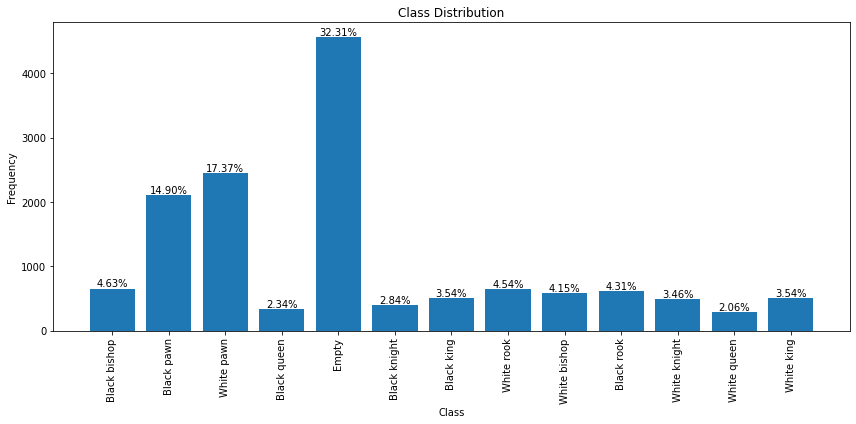

In [13]:
# Load the class ditribution from the JSON file
with open("class_distribution_balanced.json", "r") as f:
    class_distribution_balanced = json.load(f)
    
plot_class_distribution(class_distribution_balanced)